## Chapter 16 - Metric-Predicted Variable on One or Two Groups

- [16.1 - Estimating the mean and standard deviation of a normal distribution](#16.1---Estimating-the-mean-and-standard-deviation-of-a-normal-distribution)
- [16.2 - Outliers and robust estimation: the t distribution](#16.2---Outliers-and-robust-estimation:-the-t-distribution)
- [16.3 - Two Groups](#16.2---Two-Groups)


In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import norm, t
from IPython.display import Image

plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p matplotlib,numpy,pandas,pymc,seaborn,scipy

matplotlib: 3.5.1
numpy     : 1.23.1
pandas    : 1.4.3
pymc      : 5.0.0
seaborn   : 0.12.2
scipy     : 1.8.1



### Data

In [3]:
df = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Score   120 non-null    int64   
 1   Group   120 non-null    category
dtypes: category(1), int64(1)
memory usage: 1.3 KB


In [4]:
df.head()

,Score,Group
0,102,Smart Drug
1,107,Smart Drug
2,92,Smart Drug
3,101,Smart Drug
4,110,Smart Drug


In [5]:
# Mean and standard deviation
df.groupby('Group').agg(['mean', 'std'])

Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

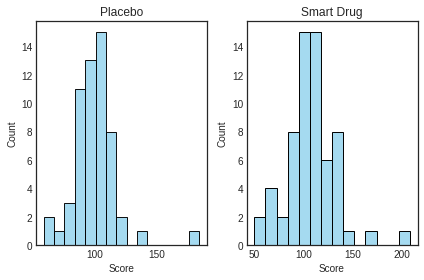

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for i, group in enumerate(["Placebo", "Smart Drug"]):
    sns.histplot(x="Score", color="#87ceeb", data=df[df["Group"] == group], ax=axes[i])
    axes[i].title.set_text(group)
plt.tight_layout()

In [7]:
# we are only interested in the scores of group "Smart Drug"
y = df[df["Group"] == "Smart Drug"]["Score"]

### 16.1 - Estimating the mean and standard deviation of a normal distribution

#### Model (Kruschke, 2015)

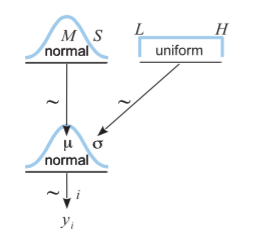

In [8]:
Image('images/fig16_2.png', width=300)

In [9]:
with pm.Model() as model:
    mu = pm.Normal("mu", y.mean(), sigma=y.std())
    sigma = pm.Uniform("sigma", y.std() / 1000, y.std() * 1000)

    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pm.Normal("likelihood", mu, sigma=sigma, observed=y)

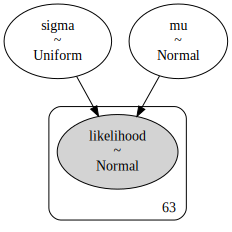

In [10]:
pm.model_to_graphviz(model)

In [11]:
with model:
    idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


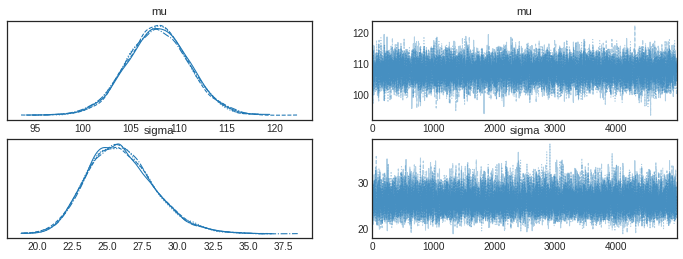

In [12]:
az.plot_trace(idata);

#### Figure 16.3

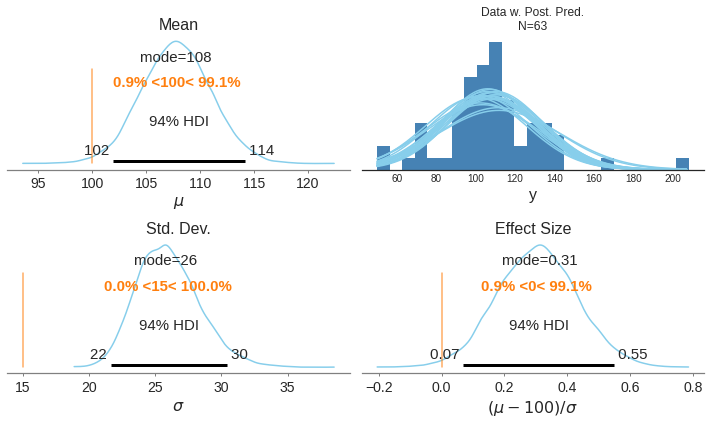

In [13]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(10, 6))

font_d = {"size": 16}

# Upper left
pm.plot_posterior(
    idata.posterior["mu"], point_estimate="mode", ref_val=100, ax=ax1, color=color
)
ax1.set_xlabel("$\mu$", fontdict=font_d)
ax1.set_title("Mean", fontdict=font_d)

# Upper right
tr_len = idata.posterior.sizes["draw"]
# Plot only 20 posterior prediction curves.
n_curves = 20
# Create an index of length 20 with which we step through the trace.
stepIdxVec = np.arange(0, tr_len, tr_len // n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1, 1), (1, n_curves))
# x = np.linspace(y.min(), y.max(), n_curves)

ax2.hist(y, bins=25, density=True, color="steelblue")
ax2.plot(
    x,
    norm.pdf(
        x,
        idata.posterior["mu"].sel(chain=0, draw=stepIdxVec),
        idata.posterior["sigma"].sel(chain=0, draw=stepIdxVec),
    ),
    c=color,
)
ax2.set_xlabel("y", fontdict=font_d)
ax2.set_title("Data w. Post. Pred.\nN=63")
[ax2.spines[spine].set_visible(False) for spine in ["left", "right", "top"]]
ax2.yaxis.set_visible(False)

# Lower left
pm.plot_posterior(
    idata.posterior["sigma"], point_estimate="mode", ref_val=15, ax=ax3, color=color
)
ax3.set_xlabel("$\sigma$", fontdict=font_d)
ax3.set_title("Std. Dev.", fontdict=font_d)

# Lower right
pm.plot_posterior(
    (idata.posterior["mu"] - 100) / idata.posterior["sigma"],
    point_estimate="mode",
    ref_val=0,
    ax=ax4,
    color=color,
)
ax4.set_title("Effect Size", fontdict=font_d)
ax4.set_xlabel("$(\mu - 100)/\sigma$", fontdict=font_d)

plt.tight_layout()

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,107.810,3.240,101.944,114.122,0.022,0.016,20951.0,13528.0,1.0
sigma,25.974,2.374,21.653,30.429,0.017,0.012,18424.0,14027.0,1.0


Mean of *mu* is 108ish, mean of *sigma* is 26ish.  What is the mean effect size (e.g., (mean-100)/sigma)?  About 0.3 or so?  Did you forget that *mu* and *sigma* are simply 2 dimensions of a multivariate posterior?  To determine our posterior for the effect size, we need to calculate the effect size for each *mu*-*sigma* **pair** that we have in our trace (our logbook).  Then we can take the mean of these effect sizes.

In [15]:
((idata.posterior["mu"] - 100) / idata.posterior["sigma"]).mean()

<xarray.DataArray ()>
array(0.30304156)

Fortunately (for you), your initial guess wasn't that far off because *mu* and *sigma* are distributed more or less independently.  But next time you may not be so lucky!

In [16]:
# test mu parameter against 100 (definitionally 'average' within the population)
(idata.posterior["mu"] > 100).mean()

<xarray.DataArray 'mu' ()>
array(0.9912)

In [17]:
# test mu parameter against 15 (definitionally the SD of the population)
(idata.posterior["sigma"] > 15).mean()

<xarray.DataArray 'sigma' ()>
array(1.)

In [18]:
# test the standardized effect size against zero
# i.e., what is the probability that the mean is > 0 SDs above 100?
(((idata.posterior['mu']-100)/idata.posterior['sigma']) > 0).mean()

<xarray.DataArray ()>
array(0.9912)

In [19]:
# test effect size against 0.1 (e.g., top of Kruschke's ROPE)
# i.e., what is the probability that the mean is > 0.1 SDs above 100?
(((idata.posterior['mu']-100)/idata.posterior['sigma'])>0.1).mean()

<xarray.DataArray ()>
array(0.94885)

### 16.2 - Outliers and robust estimation: the t distribution

#### Model

In [20]:
with pm.Model() as model2:
    mu = pm.Normal("mu", y.mean(), sigma=y.std())
    sigma = pm.Uniform("sigma", y.std() / 1000, y.std() * 1000)
    nu_minus1 = pm.Exponential("nu_minus1", 1 / 29)
    nu = pm.Deterministic("nu", nu_minus1 + 1)

    likelihood = pm.StudentT("likelihood", nu, mu, sigma=sigma, observed=y)

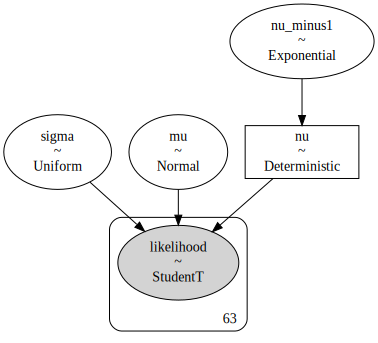

In [21]:
pm.model_to_graphviz(model2)

In [22]:
with model2:
    idata2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


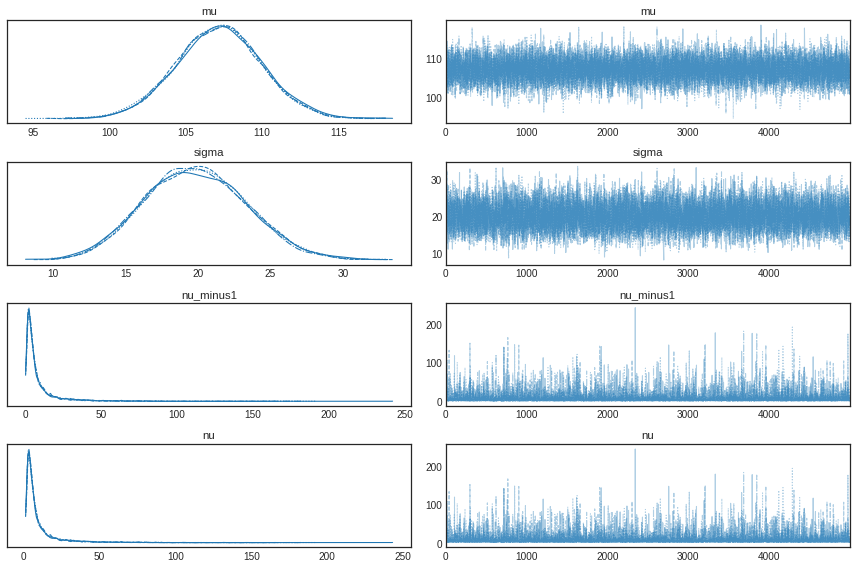

In [23]:
az.plot_trace(idata2)
plt.tight_layout();

#### Figure 16.9

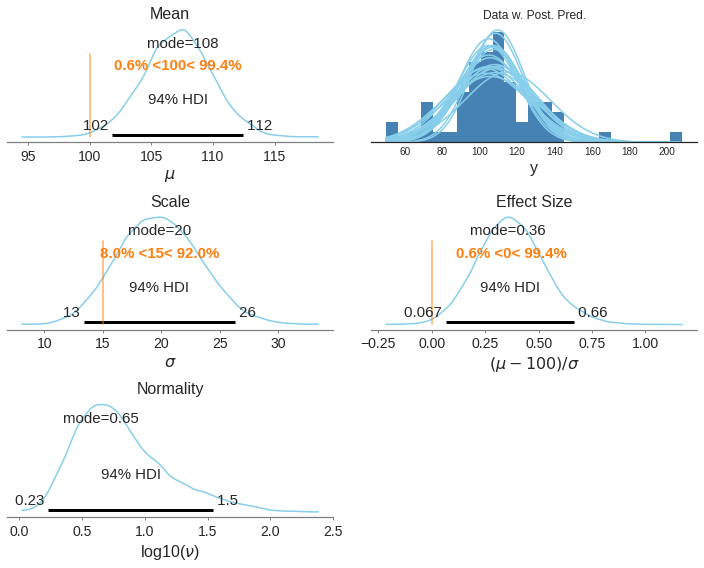

In [24]:
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3, 2, figsize=(10, 8))

# Upper left
pm.plot_posterior(
    idata2.posterior["mu"], point_estimate="mode", ref_val=100, ax=ax1, color=color
)
ax1.set_xlabel("$\mu$", fontdict=font_d)
ax1.set_title("Mean", fontdict=font_d)

# Upper right
tr_len = idata2.posterior.sizes["draw"]
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len // n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1, 1), (1, 20))

ax2.hist(y, bins=25, density=True, color="steelblue")
ax2.plot(
    x,
    norm.pdf(
        x,
        idata2.posterior["mu"].sel(chain=0, draw=stepIdxVec),
        idata2.posterior["sigma"].sel(chain=0, draw=stepIdxVec),
    ),
    c="#87ceeb",
)
ax2.set_xlabel("y", fontdict=font_d)
ax2.set_title("Data w. Post. Pred.")
[ax2.spines[spine].set_visible(False) for spine in ["left", "right", "top"]]
ax2.yaxis.set_visible(False)

# Middle left
pm.plot_posterior(
    idata2.posterior["sigma"], point_estimate="mode", ref_val=15, ax=ax3, color=color
)
ax3.set_xlabel("$\sigma$", fontdict=font_d)
ax3.set_title("Scale", fontdict=font_d)

# Middle right
pm.plot_posterior(
    (idata2.posterior["mu"] - 100) / idata2.posterior["sigma"],
    point_estimate="mode",
    ref_val=0,
    ax=ax4,
    color=color,
)
ax4.set_title("Effect Size", fontdict=font_d)
ax4.set_xlabel("$(\mu - 100)/\sigma$", fontdict=font_d)

# Lower left
pm.plot_posterior(
    np.log10(idata2.posterior["nu"]), point_estimate="mode", ax=ax5, color=color
)
ax5.set_title("Normality", fontdict=font_d)
ax5.set_xlabel(r"log10($\nu$)", fontdict=font_d)

plt.tight_layout()
ax6.set_visible(False)

Note that *sigma* does **not** control the standard deviation of the *t*-distribution.  This means that comparing *sigma* against a value of 15 **is not meaningful**.  More importantly, this means that (*mu* - 100)/*sigma* is **not** a conventional standardized effect size.

In [25]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,107.160,2.806,101.815,112.434,0.028,0.019,10406.0,11140.0,1.0
sigma,19.860,3.506,13.363,26.335,0.036,0.025,9431.0,8743.0,1.0
nu_minus1,8.955,13.390,0.106,29.084,0.137,0.097,9444.0,10531.0,1.0
nu,9.955,13.390,1.106,30.084,0.137,0.097,9444.0,10531.0,1.0


In [26]:
# test mu parameter against 100 (definitionally 'average' within the population)
(idata2.posterior["mu"] > 100).mean()

<xarray.DataArray 'mu' ()>
array(0.99425)

array([[<AxesSubplot:ylabel='sigma'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu', ylabel='nu'>,
        <AxesSubplot:xlabel='sigma'>]], dtype=object)

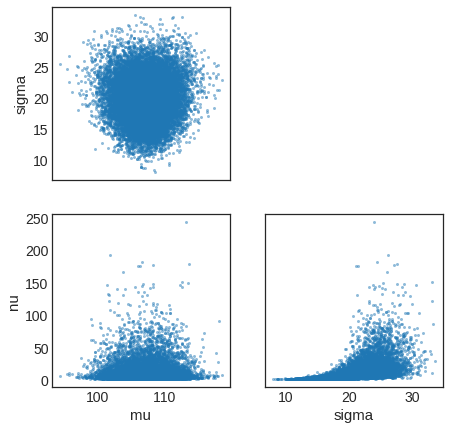

In [27]:
# lower alpha to see where the vast majority of samples are
alpha = 0.5
#alpha = 0.005
az.plot_pair(
    idata2,
    var_names=["mu", "sigma", "nu"],
    scatter_kwargs={"alpha": alpha},
    figsize=(7, 7),
)

### 16.2 - Two Groups

#### Model (Kruschke, 2015)

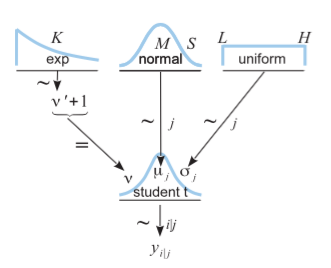

In [28]:
Image('images/fig16_11.png', width=400)

In [29]:
# compute indicies for study groups
grp_idx, grp_codes = pd.factorize(df["Group"])
n_grps = df["Group"].nunique()

with pm.Model(coords = {"group":["Smart Drug","Placebo"]}) as model3:
    mu = pm.Normal("mu", df["Score"].mean(), sigma=df["Score"].std(), dims="group")
    sigma = pm.Uniform(
        "sigma", df.Score.std() / 1000, df.Score.std() * 1000, dims="group"
    )
    nu_minus1 = pm.Exponential("nu_minus1", 1 / 29)
    nu = pm.Deterministic("nu", nu_minus1 + 1)

    likelihood = pm.StudentT(
        "likelihood", nu, mu[grp_idx], sigma=sigma[grp_idx], observed=df["Score"]
    )

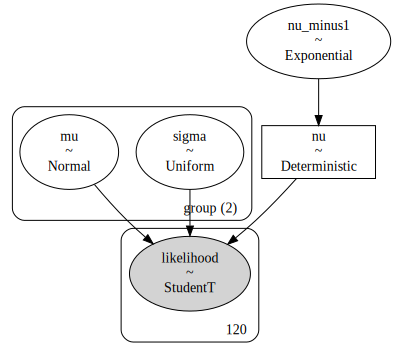

In [30]:
pm.model_to_graphviz(model3)

In [31]:
with model3:
    idata3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu_minus1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


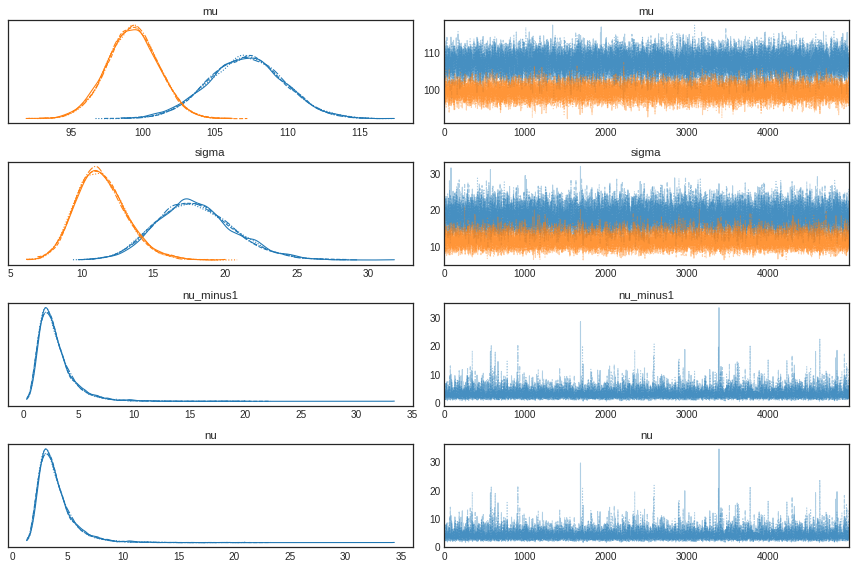

In [32]:
az.plot_trace(idata3)
plt.tight_layout();

#### Figure 16.12

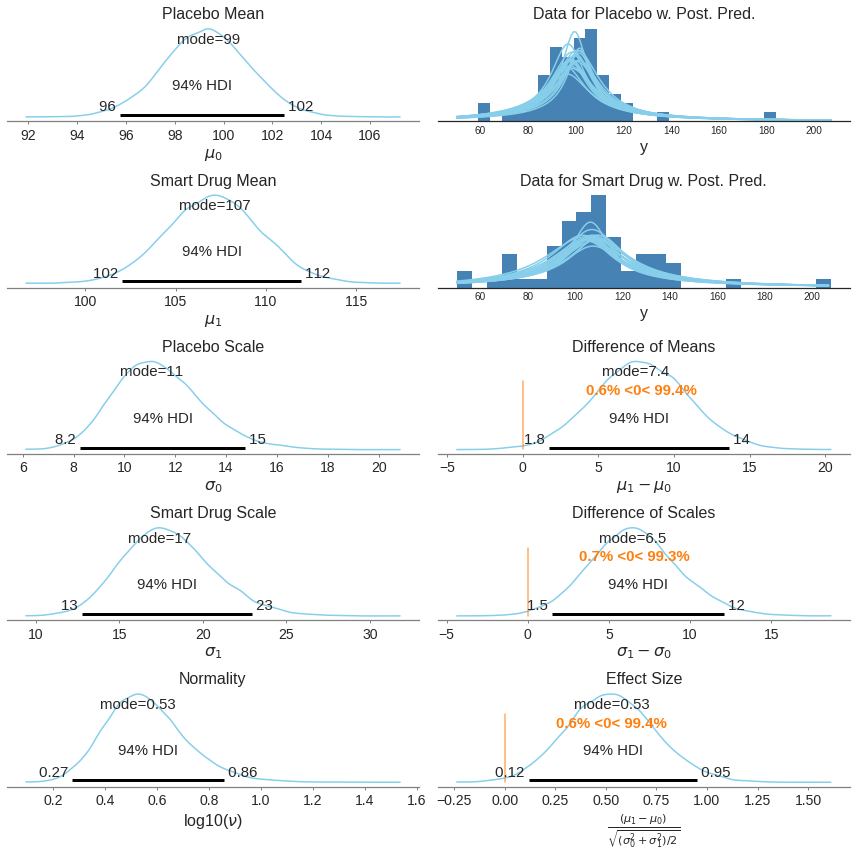

In [33]:
tr3_mu0 = idata3.posterior["mu"].sel(group="Placebo")
tr3_mu1 = idata3.posterior["mu"].sel(group="Smart Drug")
tr3_sigma0 = idata3.posterior["sigma"].sel(group="Placebo")
tr3_sigma1 = idata3.posterior["sigma"].sel(group="Smart Drug")
tr3_nu = np.log10(idata3.posterior["nu"])

fig, axes = plt.subplots(5, 2, figsize=(12, 12))

# Left column figs
l_trace_vars = (tr3_mu0, tr3_mu1, tr3_sigma0, tr3_sigma1, tr3_nu)
l_axes_idx = np.arange(5)
l_xlabels = ("$\mu_0$", "$\mu_1$", "$\sigma_0$", "$\sigma_1$", r"log10($\nu$)")
l_titles = (
    "Placebo Mean",
    "Smart Drug Mean",
    "Placebo Scale",
    "Smart Drug Scale",
    "Normality",
)

for var, ax_i, xlabel, title in zip(l_trace_vars, l_axes_idx, l_xlabels, l_titles):
    pm.plot_posterior(var, point_estimate="mode", ax=axes[ax_i, 0], color=color)
    axes[ax_i, 0].set_xlabel(xlabel, font_d)
    axes[ax_i, 0].set_title(title, font_d)

# Right column figs
tr_len = idata3.posterior.sizes["draw"]
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len // n_curves)
x_range = np.arange(df.Score.min(), df.Score.max())
x = np.tile(x_range.reshape(-1, 1), (1, n_curves))

# 1
axes[0, 1].hist(
    df.Score[df.Group == "Placebo"], bins=25, density=True, color="steelblue"
)
axes[0, 1].plot(
    x,
    t.pdf(
        x,
        loc=tr3_mu0.sel(chain=0, draw=stepIdxVec),
        scale=tr3_sigma0.sel(chain=0, draw=stepIdxVec),
        df=tr3_nu.sel(chain=0, draw=stepIdxVec),
    ),
    c="#87ceeb",
)
axes[0, 1].set_xlabel("y", font_d)
[axes[0, 1].spines[spine].set_visible(False) for spine in ["left", "right", "top"]]
axes[0, 1].yaxis.set_visible(False)
axes[0, 1].set_title("Data for Placebo w. Post. Pred.", font_d)

# 2
axes[1, 1].hist(
    df.Score[df.Group == "Smart Drug"], bins=25, density=True, color="steelblue"
)
axes[1, 1].plot(
    x,
    t.pdf(
        x,
        loc=tr3_mu1.sel(chain=0, draw=stepIdxVec),
        scale=tr3_sigma1.sel(chain=0, draw=stepIdxVec),
        df=tr3_nu.sel(chain=0, draw=stepIdxVec),
    ),
    c="#87ceeb",
)
axes[1, 1].set_xlabel("y", font_d)
[axes[1, 1].spines[spine].set_visible(False) for spine in ["left", "right", "top"]]
axes[1, 1].yaxis.set_visible(False)
axes[1, 1].set_title("Data for Smart Drug w. Post. Pred.", font_d)

# 3-5
r_vars = (
    tr3_mu1 - tr3_mu0,
    tr3_sigma1 - tr3_sigma0,
    (tr3_mu1 - tr3_mu0) / np.sqrt((tr3_sigma0**2 + tr3_sigma1**2) / 2),
)
r_axes_idx = np.arange(start=2, stop=5)
r_xlabels = (
    "$\mu_1 - \mu_0$",
    "$\sigma_1 - \sigma_0$",
    r"$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$",
)
r_titles = ("Difference of Means", "Difference of Scales", "Effect Size")

for var, ax_i, xlabel, title in zip(r_vars, r_axes_idx, r_xlabels, r_titles):
    pm.plot_posterior(
        var, point_estimate="mode", ref_val=0, ax=axes[ax_i, 1], color=color
    )
    axes[ax_i, 1].set_xlabel(xlabel, font_d)
    axes[ax_i, 1].set_title(title, font_d)

plt.tight_layout()

Again, the lower right panel is **not** our belief about conventional measures of standardized effect size.  We are using a *t*-distribution, which means that *sigma* is **not** the SD.

In [34]:
# mean of the "Smart Drug" group's location parameter
idata3.posterior["mu"].mean(dim=["draw", "chain"]).sel(group="Smart Drug")

<xarray.DataArray 'mu' ()>
array(107.12925354)
Coordinates:
    group    <U10 'Smart Drug'

In [35]:
# mean of the "Placebo" group's location parameter
idata3.posterior["mu"].mean(dim=["draw", "chain"]).sel(group="Placebo")

<xarray.DataArray 'mu' ()>
array(99.27871386)
Coordinates:
    group    <U10 'Placebo'

In [36]:
# belief about the difference in location parameters (i.e., the unstandardized effect size)
(
    idata3.posterior["mu"].sel(group="Smart Drug")
    - idata3.posterior["mu"].sel(group="Placebo")
).mean()

<xarray.DataArray 'mu' ()>
array(7.85053968)

In [37]:
# probability smart drug group location > placebo group location
(
    idata3.posterior["mu"].sel(group="Smart Drug")
    > idata3.posterior["mu"].sel(group="Placebo")
).mean()

<xarray.DataArray 'mu' ()>
array(0.99365)